**Analisys quality of the signs**

In [24]:
import pandas
import ast
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import json

In [25]:
data1 = pd.read_csv('/content/data_fetched2.csv', index_col='id')
data2 = pd.read_csv('/content/data_fetched3.csv', index_col='id')
data3 = pd.read_csv('/content/data_fetched4.csv', index_col='id')
data4 = pd.read_csv('/content/data_fetched5.csv', index_col='id')

data = pd.concat([data1, data2, data3, data4])

In [26]:
def parse(T):
  T = T.strip()
  if not T:
    return []
  try:
    obj = ast.literal_eval(T)
    while isinstance(obj, str):
      obj = ast.literal_eval(obj)
    return obj

  except ValueError:
    try:
      T = T.replace("'",'"')
      return json.loads(T)
    except ValueError:
      raise ValueError("No se puede parsear")

In [27]:
set(data["label"].to_list())

{'again',
 'age',
 'bad',
 'bathroom',
 'busy',
 'chat',
 'come',
 'deaf',
 'dontlike',
 'dontunderstand',
 'favorite',
 'fine',
 'friend',
 'go',
 'god',
 'goodbye',
 'great',
 'hardofhearing',
 'have',
 'havent',
 'hearing',
 'hello',
 'howareu',
 'im',
 'learn',
 'learning',
 'like',
 'myname',
 'name',
 'nicetomeetu',
 'nicetomeetyou',
 'nicetometyou',
 'no',
 'noise',
 'notalot',
 'nothing',
 'oisee',
 'ok',
 'please',
 'restaurant',
 'school',
 'seeulater',
 'seeyoulater',
 'sign',
 'singlanguaje',
 'slow',
 'sorry',
 'soso',
 'takecare',
 'teacher',
 'thanku',
 'understand',
 'want',
 'what',
 'whatsup',
 'where',
 'work',
 'yes',
 'you',
 'youname'}

In [28]:
data["sequence"] = data["sequence"].apply(parse)

In [7]:
import numpy as np

def positional_encoding(length, dim):
    pos = np.arange(length)[:, np.newaxis]
    i = np.arange(dim)[np.newaxis, :]
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(dim))
    encoding = pos * angle_rates
    encoding[:, 0::2] = np.sin(encoding[:, 0::2])
    encoding[:, 1::2] = np.cos(encoding[:, 1::2])
    return encoding


In [34]:
def flatting(sequence):
  features_tags = ['left_hand', 'right_hand', 'pose', 'face']
  seq_f = []

  for i in range(len(sequence)):
    for feature in features_tags:
      seq_f.extend(sequence[i][feature])
  return np.array(seq_f) if len(seq_f) == 2340 else None

In [35]:
data["input"] = data["sequence"].apply(flatting)

In [36]:
data = data.dropna(subset=["input"])

In [37]:
import numpy as np
import copy

def augment_sequence(sequence, noise_std=0.01, scale_range=(0.9, 1.1),
                     translation_range=(-0.05, 0.05), rotation_range=(-15, 15),
                     horizontal_flip_prob=0.5):
    """
    Aplica múltiples augmentations sobre una secuencia de frames.
    Args:
        sequence: list de dicts con keys ['left_hand','right_hand','pose','face'] y valores listas de puntos.
        noise_std: desviación estándar del ruido gaussiano.
        scale_range: rango de escalado aleatorio.
        translation_range: rango de traslación aleatoria.
        rotation_range: rango de rotación Z en grados.
        horizontal_flip_prob: probabilidad de reflejo horizontal.
    Returns:
        secuencia aumentada (misma estructura)
    """
    seq_aug = copy.deepcopy(sequence)

    # Random rotation Z
    angle_deg = np.random.uniform(*rotation_range)
    angle_rad = np.deg2rad(angle_deg)
    Rz = np.array([
        [np.cos(angle_rad), -np.sin(angle_rad), 0],
        [np.sin(angle_rad),  np.cos(angle_rad), 0],
        [0, 0, 1]
    ])

    scale = np.random.uniform(*scale_range)
    translation = np.random.uniform(*translation_range, size=3)

    do_flip = np.random.rand() < horizontal_flip_prob

    for i, frame in enumerate(seq_aug):
        for key in frame.keys():
            points = np.array(frame[key]).reshape(-1, 3)
            points *= scale
            points += translation
            points = points @ Rz.T
            points += np.random.normal(0, noise_std, points.shape)
            if do_flip:
                points[:, 0] *= -1
            frame[key] = points.flatten().tolist()

    return seq_aug


In [38]:
data_sequences = data["sequence"].to_list()
labels = data["label"].to_list()
n = 10
data_aug_sequences = []
data_aug_labels = []
for label,data_sequence in zip(labels,data_sequences):
  data_aug_sequences.extend([augment_sequence(data_sequence) for _ in range(n)])
  data_aug_labels.extend([label for _ in range(n)])
data_aug_sequences.extend(data_sequences)
data_aug_labels.extend(labels)

In [39]:
data_aug_sequences = [flatting(data_aug_sequence) for data_aug_sequence in data_aug_sequences]

/tmp/ipython-input-3029312668.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=colors, cmap='tab10')


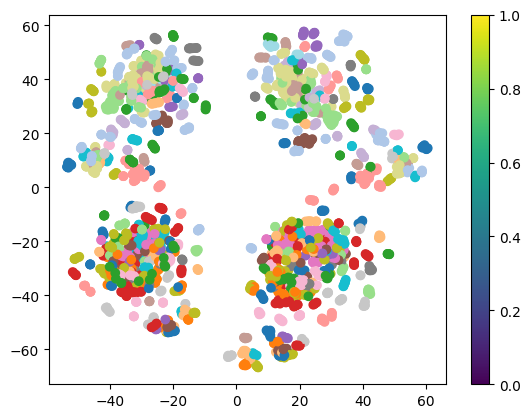

In [40]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

X = np.vstack(data_aug_sequences)
y = np.array(data_aug_labels)
tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(X)

cmap = plt.get_cmap("tab20")
unique_labels = np.unique(y)
color_dict = {label: cmap(i / len(unique_labels)) for i, label in enumerate(unique_labels)}


colors = [color_dict[label] for label in y]


plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=colors, cmap='tab10')
plt.colorbar()
plt.show()


In [41]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

X = np.vstack(data_aug_sequences)
y = np.array(data_aug_labels)

le = LabelEncoder()
y_enc = le.fit_transform(y)
y_enc = to_categorical(y_enc)

seq_len = 15
features_per_frame = X.shape[1] // seq_len
X_reshaped = X.reshape(-1, seq_len, features_per_frame)
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_enc, test_size=0.2, random_state=42)


model = Sequential([
    Bidirectional(LSTM(128, return_sequences=False), input_shape=(seq_len, features_per_frame)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(y_enc.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=32)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 256)            │       291,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 58)             │         3,770 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 312,058 (1.19 MB)

 Trainable params: 312,058 (1.19 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 72ms/step - accuracy: 0.0347 - loss: 3.9773 - val_accuracy: 0.1029 - val_loss: 3.6483
Epoch 2/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.0668 - loss: 3.6418 - val_accuracy: 0.1324 - val_loss: 3.3244
Epoch 3/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.0848 - loss: 3.3609 - val_accuracy: 0.1891 - val_loss: 2.9676
Epoch 4/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.1536 - loss: 3.0646 - val_accuracy: 0.2752 - val_loss: 2.6520
Epoch 5/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.1959 - loss: 2.8161 - val_accuracy: 0.3151 - val_loss: 2.3722
Epoch 6/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - accuracy: 0.2492 - loss: 2.5375 - val_accuracy: 0.3992 - val_loss: 2.1006
Epoch 7/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.3256 - loss: 2.2293 - val_accuracy: 0.4979 - val_loss: 1.8230
Epoch 8/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.3661 - loss: 2.0288 - val_accuracy: 0.5210 - v

In [ ]:
from sklearn.model_selection import train_test_split

X_train_dev, X_test, y_train_dev, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
)

X_train, X_dev, y_train, y_dev = train_test_split(
    X_train_dev, y_train_dev, test_size=0.1, random_state=42, stratify=y_train_dev
)


In [47]:
n_samples = X_train.shape[0]
n_features = 2340
timesteps = 15          # según tus frames
features_per_timestep = n_features // timesteps  # 2340 / 15 = 156

X_train_reshaped = X_train.reshape(n_samples, timesteps, features_per_timestep)


In [52]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from kerastuner.tuners import RandomSearch


le = LabelEncoder()
y_int = le.fit_transform(y)
y_ohe = to_categorical(y_int)


X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_ohe, test_size=0.20, random_state=42, stratify=y_ohe
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

timesteps = 15
features_per_frame = X.shape[1] // timesteps
X_train_reshaped = X_train.reshape(-1, timesteps, features_per_frame)
X_val_reshaped   = X_val.reshape(-1, timesteps, features_per_frame)
X_test_reshaped  = X_test.reshape(-1, timesteps, features_per_frame)

def build_model(hp):
    model = Sequential()
    model.add(Input(shape=(timesteps, features_per_frame)))
    model.add(LSTM(units=hp.Int('units', min_value=64, max_value=256, step=64),
                   return_sequences=False))
    model.add(Dropout(rate=hp.Float('dropout', 0.2, 0.5, step=0.1)))
    model.add(Dense(y_train.shape[1], activation='softmax'))
    model.compile(
        optimizer=Adam(hp.Choice('lr', [1e-2, 1e-3, 1e-4])),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='bilstm_tuner_clean',
    project_name='signs'
)


tuner.search(
    X_train_reshaped, y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_val_reshaped, y_val),
    verbose=2
)


best_model = tuner.get_best_models(num_models=1)[0]

test_loss, test_acc = best_model.evaluate(X_test_reshaped, y_test)
print(f"Test Accuracy: {test_acc:.4f}")


Trial 5 Complete [00h 02m 26s]
val_accuracy: 0.9957982897758484

Best val_accuracy So Far: 0.9957982897758484
Total elapsed time: 00h 09m 36s


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9900 - loss: 0.0407
Test Accuracy: 0.9916


In [53]:
best_model.save("bilstm_sign_model.keras")